In [65]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

words = open('../../names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# import random
# random.seed(42)
# random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:1])
words[:1]
#Xdev, Ydev = build_dataset(words[n1:n2])
#Xte, Yte = build_dataset(words[n2:])

torch.Size([5, 3]) torch.Size([5])


['emma']

In [66]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [69]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 5), generator=g)
b1 = torch.randn(5, generator=g)
W2 = torch.randn((5, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [70]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

for p in parameters:
  p.requires_grad = True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_hist(weights):
    # Check if weights is a PyTorch tensor and requires gradient
    if hasattr(weights, 'requires_grad') and weights.requires_grad:
        weights = weights.detach().numpy()
    elif isinstance(weights, np.ndarray):  # If it's already a numpy array
        pass
    else:
        raise ValueError("Unsupported data type for heatmap")
    
    # Plotting the heatmap for the transposed weight matrix
    plt.figure(figsize=(15, 3))
    sns.heatmap(weights, cmap='viridis', annot=True, fmt=".2f")
    plt.title('Heatmap of the Transposed Weights')

    # Move x-axis labels to the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    plt.show()


In [75]:

emb


tensor([[[ 0.9827,  0.8671],
         [ 0.9827,  0.8671],
         [ 0.9827,  0.8671]],

        [[ 0.9827,  0.8671],
         [ 0.9827,  0.8671],
         [-0.5547, -0.3200]],

        [[ 0.9827,  0.8671],
         [-0.5547, -0.3200],
         [ 3.1075, -1.7311]],

        [[-0.5547, -0.3200],
         [ 3.1075, -1.7311],
         [ 3.1075, -1.7311]],

        [[ 3.1075, -1.7311],
         [ 3.1075, -1.7311],
         [ 0.1158, -1.0480]]], grad_fn=<IndexBackward0>)

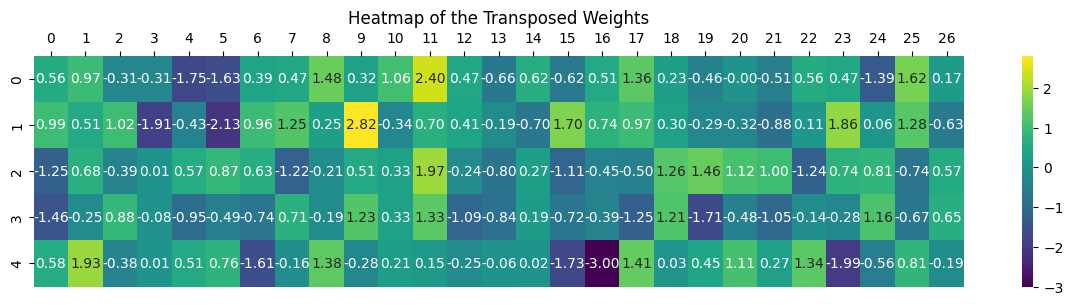

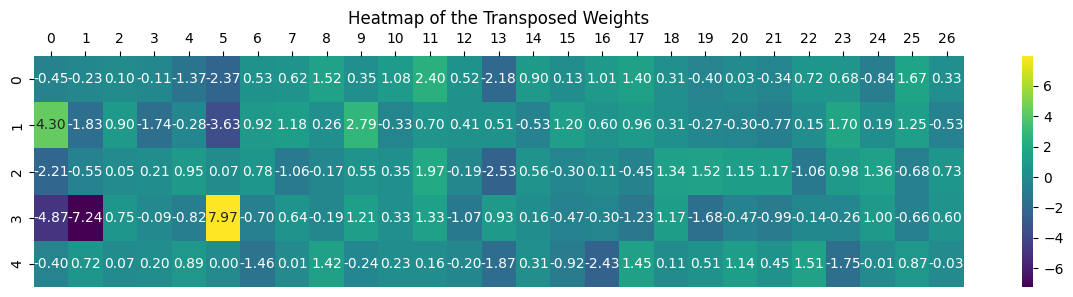

In [71]:

draw_hist(W2)
for i in range(1000):
  
  # minibatch construct
  #ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.5 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

draw_hist(W2)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose the matrix
#W1_transposed = W1.data.T

# Plotting the heatmap for the transposed weight matrix
plt.figure(figsize=(15, 3))
sns.heatmap(W1, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap of the Transposed Weights')

# Move x-axis labels to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.show()
